# Predicción de supervivéncia del Titanic

Esta práctica se divide en dos partes:
1. En la primera parte entrenaremos un conjunto de modelos de clasificación de machine learning (perceptron, regression logística y arbol de decisión) para predecir la probabilidad que tendría un pasajero del Titánic de sobrevivir.
2. En la segunda parte realizaremos el *feature importance*, que básicamente consiste en analizar la importancia que tiene cada característica en cada uno de los modelos predictivos

![OHE](https://imgs.search.brave.com/Cn_B5VSZhmV_ElcnW0wlfHZ4rn5MCPijlzLBp2IA5Eo/rs:fit:844:225:1/g:ce/aHR0cHM6Ly90c2Uy/Lm1tLmJpbmcubmV0/L3RoP2lkPU9JUC5y/RGgzRWs0dEl3QXZD/eVQ2RV9ENVpBSGFF/SyZwaWQ9QXBp)


## Parte 1

### 1.1 Importar librerias
Importamos la librerias que usaremos

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### 1.2 Cargamos el dataset
Cargamos el dataset para poder visualizar los datos que usaremos.

In [3]:
df = pd.read_csv("./dades.csv")

Para poder ver todas las columnas usamos la sigüiente instrucción de *pandas*

In [4]:
pd.set_option('display.max_columns',None)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.3 Limpieza de datos
Para poder entrenar a nuestros modelos previamente debemos "*masticar*" los datos

#### 1.3.1 Eliminar columnas (Ruido)
Lo primero que haremos será eliminar las columnas que contienen variables que no afectarán a nuestra predicción como el Id, el nombre del pasajero o el identificador del ticket

In [5]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)

In [37]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### 1.3.2 Gestion de valores Nan
Ahora vamos a mostrar la cantidad de valores que hay en cada columna

In [23]:
df.count()

Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

El número de filas es 891 y las variables que no alcanzan ese valor nos muestran la cantidad de valores nulos que contienen

La característica 'Cabin', que hace referencia al identificador de la cabina donde se hospedaba el cliente, contiene una gran cantidad de valores Nan

In [33]:
(df['Cabin'].isna().sum()/891)*100 #Porcentaje de valores Nan

77.10437710437711

Como este valor tampoco es relevante, podemos eliminar la columna

In [6]:
df = df.drop('Cabin', axis=1)

Otra cantidad un poco más pequeña de falta de valores se encuentra en la columna '*Age*', la cual podemos completar con la media de todos los pasajeros

In [7]:
df['Age'].fillna(df['Age'].median(), inplace = True)
df.count()

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Fare        891
Embarked    889
dtype: int64

Por último nos faltaria gestionar la columna '*Embarked*'. Los valores nulos de esta característica también los podriamos completar con la media si no fuera porque no son un valor numérico. Debido a esto, usaremos otro estadístico que es la moda. Este estadísctico reflejará el valor que mas se repite dentro de la muestra

In [8]:
df['Embarked'].fillna(df['Embarked'].mode(), inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


#### 1.3.3 Valores categóricos
Dentro de este dataset econtramos características como el sexo que son incompatibles con el aprendizaje de los modelos predictivos. Para ello debemos conseguir que todas la columnas de nuestro conjunto de datos contengan valores numéricos.
Para solucionar esto usaremos la técnica de **One hot encoding** que consiste en ampliar el número de columnas según los posibles valores y rellenarlas con un valor binario.
![OHE](https://www.statology.org/wp-content/uploads/2021/09/oneHot1.png)

Realizaremos esto con las columnas '*Sex*' y '*Embarked*' 

In [9]:
#Para el sexo
clb = df.pop("Sex")
ohe_clb = pd.get_dummies(clb, prefix='sexo')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,sexo_female,sexo_male
0,0,3,22.0,1,0,7.2500,S,0,1
1,1,1,38.0,1,0,71.2833,C,1,0
2,1,3,26.0,0,0,7.9250,S,1,0
3,1,1,35.0,1,0,53.1000,S,1,0
4,0,3,35.0,0,0,8.0500,S,0,1


In [ ]:
#Para el Embarque
clb = df.pop("Embarked")
ohe_clb = pd.get_dummies(clb, prefix='embarque')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

Ahora debemos pasar todos los valores de las columnas a el mismo tipo de dato. En este caso haremos que todos sean floats de 64 bits para mantener los decimales en '*Age*' y '*Fare*'.

In [23]:
for column in df:
    df[column]=df[column].astype(float)

,Survived,Pclass,Age,SibSp,Parch,Fare,sexo_female,sexo_male,embarque_C,embarque_Q,embarque_S
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,27.0,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,1.0
887,1.0,1.0,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0
888,0.0,3.0,28.0,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0
889,1.0,1.0,26.0,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0


#### 1.3.4 Relación entre variables
Ahora mostramos la matriz de correlación para intentar entcontrar valores dependientes o redundantes

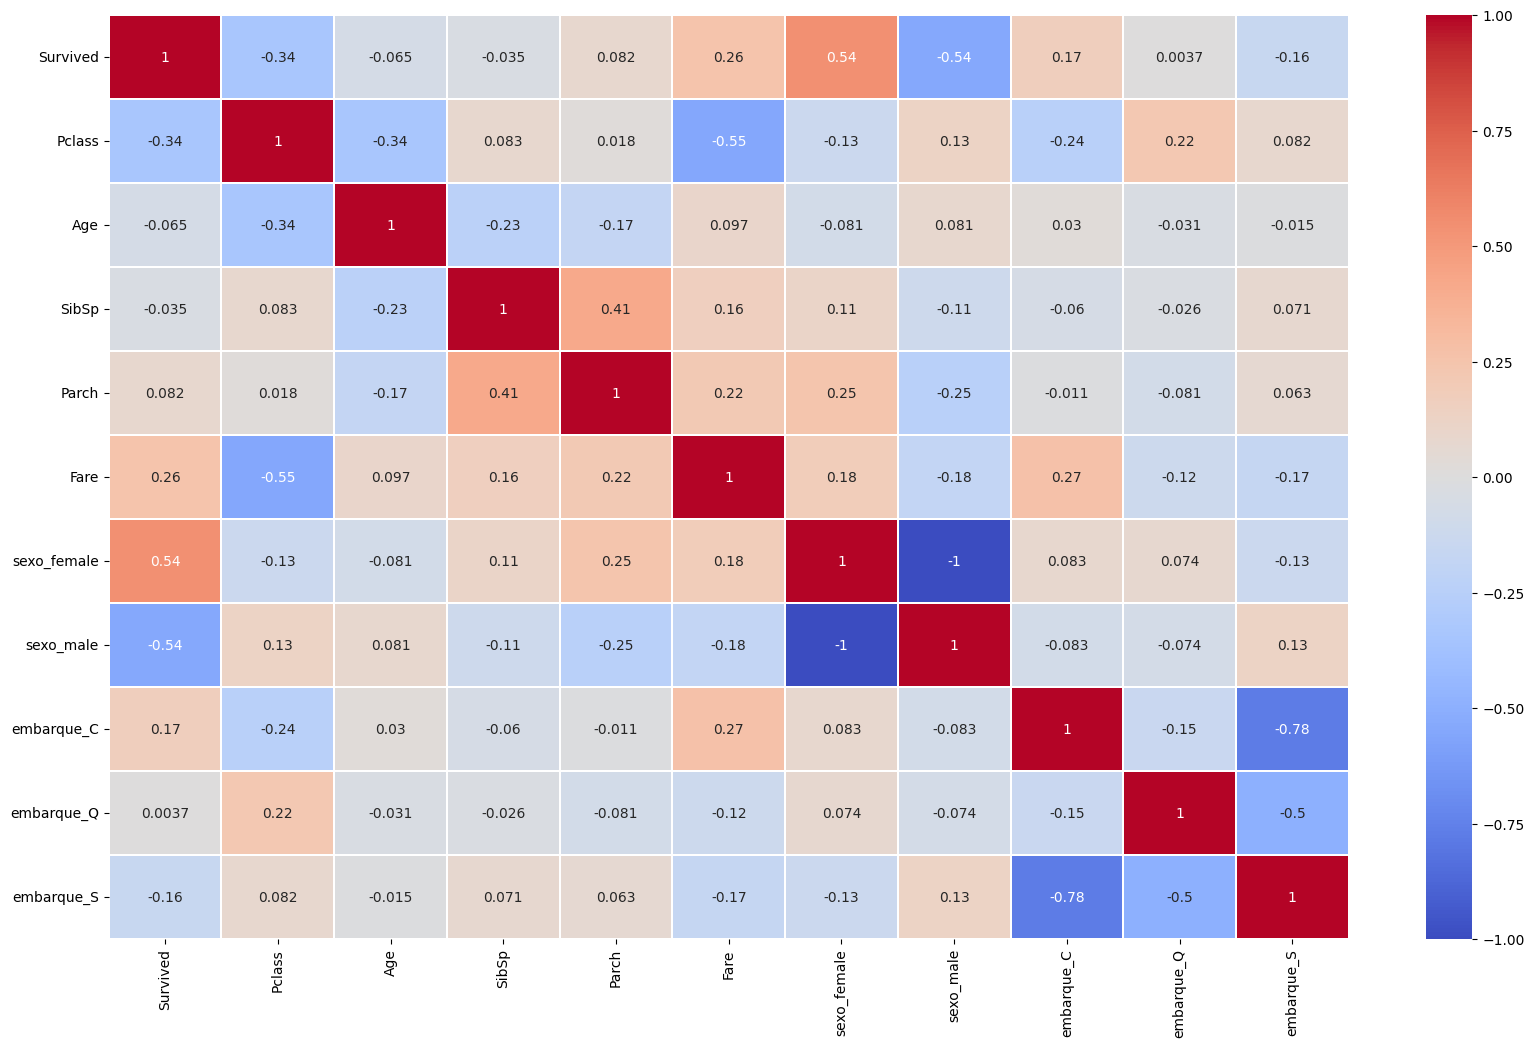

In [25]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### 1.4 Modelos
Ahora procedemos a crear y entrenar los distintos modelos con los datos anteriormente revisados, para así evaluar su precisión. 
Importamos las librerias necesarias

In [43]:
#Dividir datos para evitar overfitting y poder evaluar
from sklearn.model_selection import train_test_split 
#Precisión
from sklearn.metrics import accuracy_score
#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

Dividimos los datos entre entrenamiento y evaluación, habiendo separado previamente el objetivo que queremos predecir, en este caso '*Survived*'

In [123]:
X_data = df.drop("Survived",axis=1)
Objetivo = df["Survived"]
X_train,X_test,y_train,y_test = train_test_split(X_data,Objetivo,test_size=0.33,random_state=42)

#### 1.4.1 Regresión Logística
Este método estadístico trata de modelar la probabilidad de una variable cualitativa binaria, en este caso '*Survived*', en función de una o más variables como las que tenemos en el dataset.
Esta modelo sigue una función sigmoide:
![OHE](https://wikimedia.org/api/rest_v1/media/math/render/svg/9f9655dad99527a46d3d532543360135b492dfd2)  

Esta función es continua y derivable. En este caso, no la podemos observar gráficamente puesto que el numero de dimensiones no es observable.
Con la libreria sklearn podemos crear este modelo y reducir el error de su '*loss function*' o lo que se conoce como entrenamiento. 

Creamos el modelo y lo entrenamos

In [124]:
modeloLR = LogisticRegression(max_iter=900)
modeloLR.fit(X_train,y_train)
prediction_lr=modeloLR.predict(X_test)
print('The accuracy of the Logistic Regression is',round(accuracy_score(prediction_lr,y_test)*100,2))

The accuracy of the Logistic Regression is 81.36


#### 1.4.2 Perceptron
Un perceptrón es un modelo matemático inspirado en una estructura y función simplificadas de una única neurona biológica. 
Los valores de entrada múltiples alimentan el modelo del perceptrón, el modelo se ejecuta con los valores de entrada, y si el valor estimado es el mismo que la salida requerida, entonces el rendimiento del modelo se encuentra satisfecho, por lo que los pesos no exigen cambios. De hecho, si el modelo no cumple con el resultado requerido, entonces se realizan algunos cambios en los pesos para minimizar los errores.

![OHE](https://imgs.search.brave.com/5JQsB-RHZyxiVSzvuvb83kMMZ4APv1-LbMeA3SJCdI4/rs:fit:629:302:1/g:ce/aHR0cHM6Ly9hbGV4/YW5kZXJoYXkyMDIw/LmdpdGh1Yi5pby9h/c3NldHMvaW1nL25u/XzAyLnBuZw)

Creamos el modelo y lo entrenamos

In [125]:
modeloPer = Perceptron(random_state=42)
modeloPer.fit(X_train,y_train)
prediction_per=modeloPer.predict(X_test)
print('The accuracy of the Perceptron is',round(accuracy_score(prediction_lr,y_test)*100,2))

The accuracy of the Perceptron is 81.36


#### 1.4.3 Clasificador de Árbol de Decision
Como su nombre indica, esta técnica de machine learning toma una serie de decisiones en forma de árbol. Los nodos intermedios (las ramas) representan soluciones. Los nodos finales (las hojas) nos dan la predicción que vamos buscando.
decision

En cada nodo del árbol se debe tomar una decisión entre un valor atribuido a dicho nodo. Para asignar los atributos de decisión más predecibles a los nodos se usa la entropia, que representa la homogeneidad de las muestras en ese nodo:
![OHE](https://www.maximaformacion.es/wp-content/uploads/2021/07/formula-de-la-entropia.jpg.webp)

Una vez decidios los parametros de los nodos ya está formado el modelo que decide:
![OHE](https://imgs.search.brave.com/8PTRz3Dd3BnAKnDBaItdO9JaqsOSOJ0Icte7UpTAka4/rs:fit:663:528:1/g:ce/aHR0cHM6Ly9taXJv/Lm1lZGl1bS5jb20v/bWF4LzEzMjYvMSp4/R3NZYzZhWGVoRDds/eW9MRW4tbU1BLnBu/Zw)

Creamos el modelo y lo entrenamos

In [126]:
modeloArbol= DecisionTreeClassifier(criterion='gini', 
                             min_samples_split=10,min_samples_leaf=1, max_features='sqrt')
modeloArbol.fit(X_train,y_train)
prediction_tree=modeloArbol.predict(X_test)
print('The accuracy of the DecisionTree Classifier is',round(accuracy_score(prediction_tree,y_test)*100,2))

The accuracy of the DecisionTree Classifier is 80.68
